In [ ]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np
import os
import math

provider = QuantumRingsProvider(token=os.environ.get('TOKEN_QUANTUMRINGS'), name=os.environ.get('ACCOUNT_QUANTUMRINGS'))
backend = provider.get_backend("scarlet_quantum_rings")
shots = 100

provider.active_account()

In [6]:
def set_reg(qc, input, q, n):
    """
    Sets a quantum register with an input value.

    Args:
        qc (QuantumCircuit):
            The quantum circuit to use

        input (int):
            The number to be stored in the qubit register

        q (QuantumRegister):
            The qubit register which is to be programmed with the input number

        n (int):
            The width of the qubit register to use.

    Returns:
        None.

    """

    for i in range (0, n):
        if ((1 << i) & input ):
            qc.x(q[i])
    return



def add_cct(qc,a, b, n):
    """
    The adder circuit in the Fourier Basis

    Args:
        qc (QuantumCircuit):
            The quantum circuit

        a (QuantumRegister):
            The source register

        b (QuantumRegister):
            The target register

        n (int):
            The number of qubits in the registers to use

    Returns:
        None

    """

    while (n):
        for i in range(n, 0, -1):
            qc.cu1(math.pi/2**(n - i), a[i-1], b[n-1])
        n -= 1
        qc.barrier()
    return



def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(  -math.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return


def qft_cct(qc, b, n):
    """
    The Forward QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    while (n):
        qc.h(b[n-1])
        for i in range (n-1, 0, -1):
            qc.cu1(math.pi / 2** (n - i ), b[i - 1], b[n-1])
        n -= 1
        qc.barrier()
    return


def add_qft(qc, input1, input2, a, b, n):
    """
    The adder using QFT.

    Args:

        qc (QuantumCircuit):
            The quantum circuit

        input1 (int):
            The first number

        input2 (int):
            The second number to add.

       a (QuantumRegister):
            The source register

        b (QuantumRegister):
            The target register. Computed value is stored in this register

        n (int):
            The number of qubits in the registers to use

    Returns:
        None

    """
    set_reg(qc, input1, a, n)
    set_reg(qc, input2, b, n)

    qft_cct(qc, b, n)
    add_cct(qc, a, b, n)
    iqft_cct(qc, b, n)
    return

def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

Enter the first number as the binary value:  1010101010101
Enter the second number as the binary value:  10001000111


Number of qubits required in each register:  14
Job Running
Job Done.
Ending Job Monitor


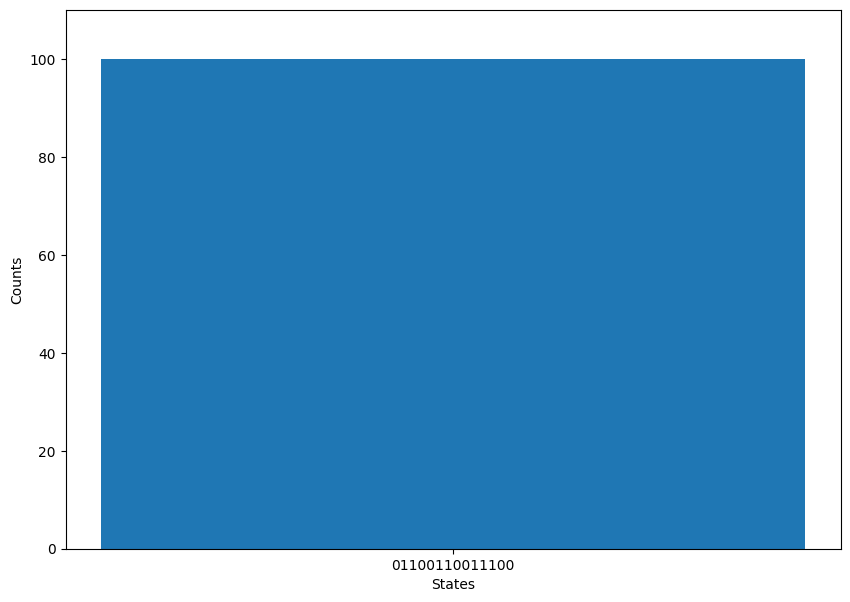

In [7]:
# obtain the hidden string from the user
input_a = int(input("Enter the first number as the binary value: "), 2)
input_b = int(input("Enter the second number as the binary value: "), 2)

# determine the number of qubits required to represent the hidden string
# add one more qubit to handle the carry. This is essentially needed in the second bank, though.

numberofqubits = max(input_a.bit_length(), input_b.bit_length()) + 1

print("Number of qubits required in each register: ", numberofqubits)


q1 = QuantumRegister(numberofqubits , 'a')
q2 = QuantumRegister(numberofqubits , 'b')
c = ClassicalRegister(numberofqubits , 'c')
qc = QuantumCircuit(q1, q2, c)

add_qft(qc, input_a, input_b, q1, q2, numberofqubits)

for i in range (q2.size()):
    qc.measure(q2[i])

job = backend.run(qc, shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

# clean-up the circuit components
del q1
del q2
del c
del qc

plot_histogram(counts,"")

# clean-up
del result
del job